# KAGGLE Ames Housing Prices Regression Competition

An advanced regression task using housing data to predict the sales price of various houses in Ames, Iowa.

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

import warnings

warnings.filterwarnings("ignore")

# load data
data = pd.read_csv("../data/train.csv")
data_test = pd.read_csv("../data/test.csv")

## Feature Extraction and Preprocessing

Defining multiple helper functions and Pipeline classes (which inherit from BaseEstimator and TransformerMixin s.t. we can easily insert these classes into a sklearn.pipline.Pipeline object.

In [2]:
# numerical features pipeline
# helper function for preprocessing pipelines below
def numerical_value_for_rating(rating):
    if rating == "Ex":
        num_value = 5
    elif rating == "Gd":
        num_value = 4
    elif rating == "TA":
        num_value = 3
    elif rating == "FA":
        num_value = 2
    elif rating == "Po":
        num_value = 1
    else:
        num_value = 0
    return num_value

# define preprocessing pipeline steps
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, selection):
        self.selection = selection
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.selection]
    
class AddNumAttr(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # turn the originally cat classes into quality integer features
        quality_classes = [
            "ExterQual",
            "ExterCond",
            "BsmtCond",
            "HeatingQC",
            "GarageQual",
            "GarageCond"
        ]
        
        # choose quality classes present in the input dataframe
        quality_classes = set(quality_classes).intersection(set(X.columns.tolist()))
        
        for col in quality_classes:
            X[col] = [numerical_value_for_rating(item) for item in X[col]]
        
        return X
        
class AddBinaryAttr(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        binary_feature_cols = [
            "Fireplaces",
            "WoodDeckSF",
            'OpenPorchSF', 
            'EnclosedPorch', 
            '3SsnPorch', 
            'ScreenPorch', 
            'PoolArea'
        ]
        
        for col in binary_feature_cols:
            X[col] = [bool(item) for item in X[col]]

        return X.astype("category")
    
class DummyVariableEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.get_dummies(X)

### Numerical Feature Selection

In [3]:
# get all numerical features + add ordinal categorical feature names
ordinal_attrs = [
    "ExterQual",
    "ExterCond",
    "BsmtCond",
    "HeatingQC",
    "GarageQual",
    "GarageCond"
]

tot_num_attrs = data.select_dtypes(exclude="object").columns.tolist() + ordinal_attrs

# define preprocessing pipeline for numerical and categorical features
num_pipeline = Pipeline([("Selector", DataFrameSelector(tot_num_attrs)),
                         ("NumAttrsAdder", AddNumAttr()),
                         ("Imputer", SimpleImputer(strategy="most_frequent"))])

out = num_pipeline.fit_transform(data.copy())
df = pd.DataFrame(out, columns=tot_num_attrs)

df["SalePrice"] = np.log(df["SalePrice"])

label_corr = df.corr()["SalePrice"]

# print all features with label correlation abs. value above threshold
threshold = 0.2

filtered_features = label_corr[abs(label_corr) > threshold]

filtered_features.sort_values(ascending=False)

SalePrice       1.000000
OverallQual     0.817184
GrLivArea       0.700927
GarageCars      0.680625
ExterQual       0.653802
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
TotRmsAbvGrd    0.534422
Fireplaces      0.489449
HeatingQC       0.449137
MasVnrArea      0.426775
GarageYrBlt     0.406004
BsmtFinSF1      0.372023
GarageCond      0.371079
GarageQual      0.368057
WoodDeckSF      0.334135
LotFrontage     0.323534
OpenPorchSF     0.321053
2ndFlrSF        0.319300
HalfBath        0.313982
BsmtCond        0.285189
LotArea         0.257320
BsmtFullBath    0.236224
BsmtUnfSF       0.221985
BedroomAbvGr    0.209044
Name: SalePrice, dtype: float64

Visualize the top 8 features and their scatter plots for the various datapoints in the datasets.

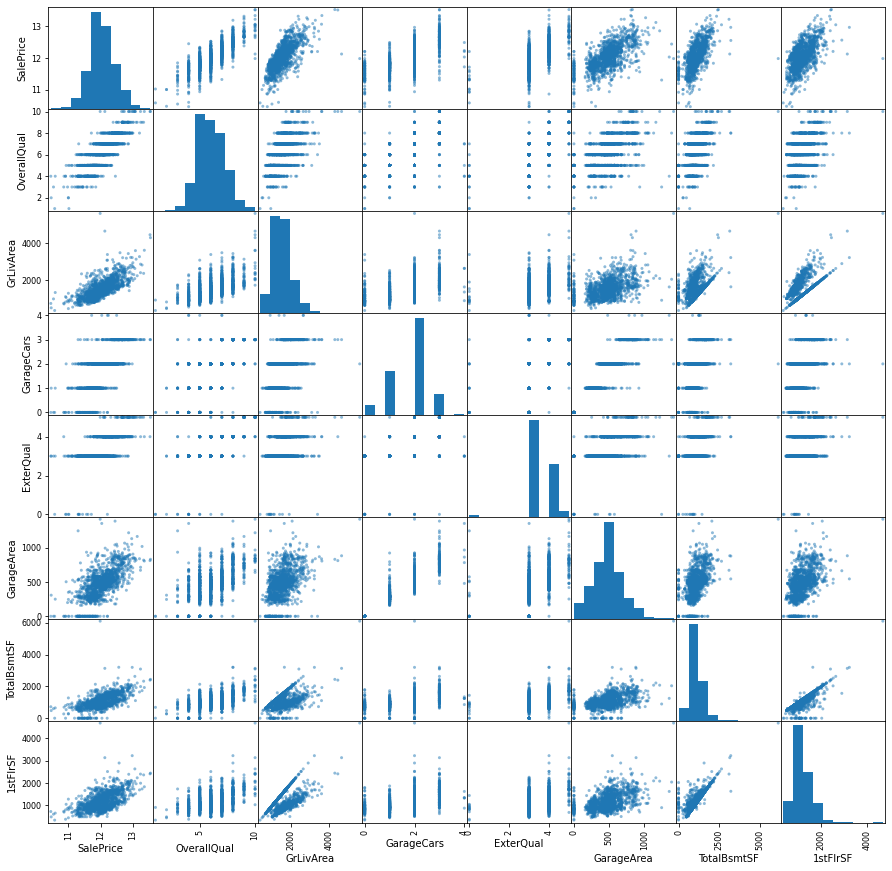

In [4]:
data_vis = df[filtered_features.sort_values(ascending=False).index[:8]]
pd.plotting.scatter_matrix(data_vis,
                          figsize=(15,15))
plt.show()

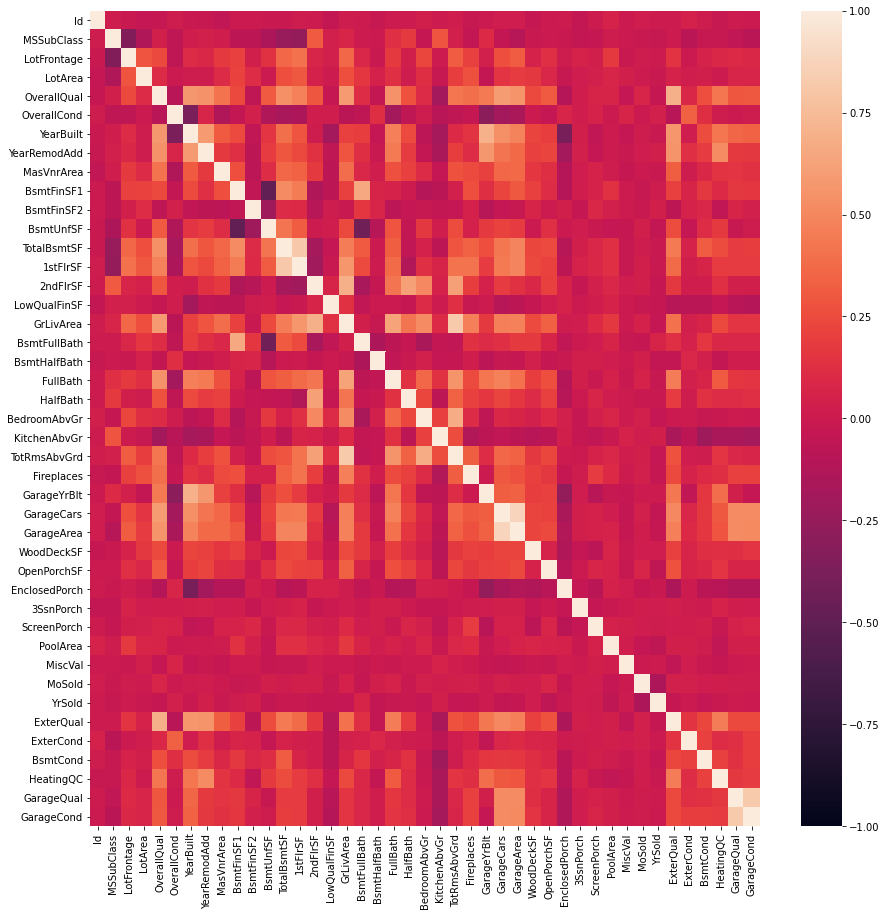

In [5]:
# plot the corr matrix between the numerical features
corr = df.drop(columns="SalePrice").corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, vmax=1, vmin=-1)
plt.show()

In [6]:
# filter out correlations with abs value of pearson coef above threshold
threshold = 0.8

columns = corr.columns
boolean_indices = []
for item in columns:
    if item in filtered_features.index:
        boolean_indices.append(True)
    else:
        boolean_indices.append(False)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) > threshold:
            
            index = np.argmin((abs(label_corr[i]), abs(label_corr[j])))
            
            if boolean_indices[(i,j)[index]]:
                boolean_indices[(i,j)[index]] = False
            
            print(f"Features: {columns[i]}[{label_corr[i].round(2)}] & {columns[j]}[{label_corr[j].round(2)}], value {corr.iloc[i, j]}")
            print(70*"-")

numerical_attrs = columns[boolean_indices]

# the brackets denote the overall label correlation

Features: TotalBsmtSF[0.61] & 1stFlrSF[0.6], value 0.8195299750050355
----------------------------------------------------------------------
Features: GrLivArea[0.7] & TotRmsAbvGrd[0.53], value 0.8254893743088377
----------------------------------------------------------------------
Features: GarageCars[0.68] & GarageArea[0.65], value 0.8824754142814603
----------------------------------------------------------------------
Features: GarageQual[0.45] & GarageCond[0.37], value 0.8237674058868807
----------------------------------------------------------------------


We'll choose all the top > threshold abs value label correlation features from above and remove the ones that are highly correlated between each other. So the features we'll keep are:

- TotalBsmtSF
- GrLivArea
- GarageCars
- GarageQual

The features we'll remove due to their correlation with another are:

- 1stFlrSF
- TotRmsAbvGrd
- GarageArea
- GarageCond

(this is implemented in the code above via boolean indexing)

Let us quickly visualize the features that have been cut from having too low correlation with the labels. As we recall the Pearson correl. only captures linear dependency. By visualizing the cut features we can perhaps observe interesting patterns that are not captured by linear interdependence.

{'KitchenAbvGr', 'ExterCond', 'LowQualFinSF', 'OverallCond', 'GarageCond', 'EnclosedPorch', 'MiscVal', 'BsmtHalfBath', '1stFlrSF', 'MoSold', 'GarageArea', 'MSSubClass', '3SsnPorch', 'BsmtFinSF2', 'ScreenPorch', 'PoolArea', 'YrSold', 'TotRmsAbvGrd'}


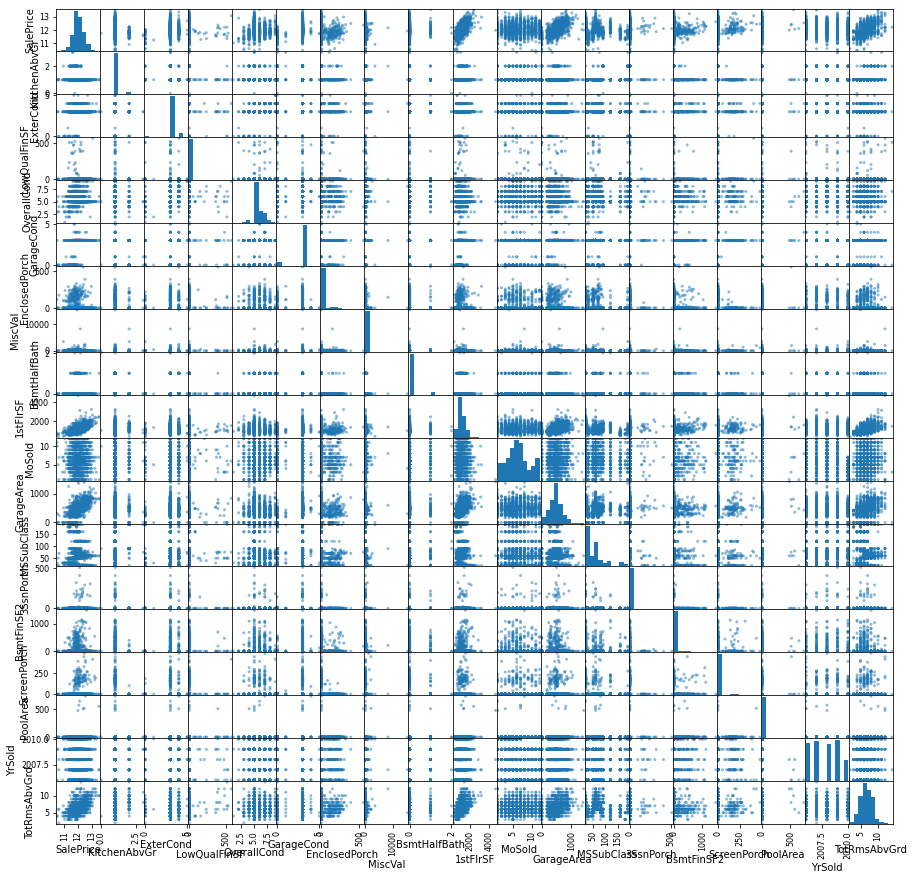

In [7]:
# remove Id and add SalePrice to the first place in the scatter plot
cut_features = set(df.columns) - set(numerical_attrs.tolist()) - {"Id", "SalePrice"}
print(cut_features)
cut_features = ["SalePrice"] + list(cut_features)

data_vis = df[cut_features]
pd.plotting.scatter_matrix(data_vis,
                          figsize=(15,15))
plt.show()

After visualizing these scatter plots it could be beneficial to add OverallCond and EnclosedPorch to the numerical features, as they do show a positive correlation with the label. Importantly the correl. coef. for EnclosedPorch & ScreenPorch seems to be diluted by a lot of datapoints without any Porch, as soon as a Porch is present there seems to be an interdependency between EnclosedPorch/ScreenPorch area and the SalePrice!

It is always important to note that we are missing certain datapoints in the datadistribution (i.e. sampling biases) and therefore actual interdependencies between features are hidden to us given this sample.

In [8]:
# final number of numerical attrs
additional_num_attrs = ["OverallCond", "EnclosedPorch", "ScreenPorch"]
filtered_num_attrs = numerical_attrs.tolist() + additional_num_attrs
filtered_num_attrs

['LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'ExterQual',
 'BsmtCond',
 'HeatingQC',
 'GarageQual',
 'OverallCond',
 'EnclosedPorch',
 'ScreenPorch']

### Categorical Feature Selection

We will repeat the above derivation for categorical features now as well. 

1. Find the highest correlated binary encoded categories (e.g. Fireplaces True/False)
2. Find highly correlated features and remove them due to multicollinearity issues

Finally input these features into the pipeline and combine with the numerical features to result in our final dataset.

In [9]:
cat_attrs = set(data.select_dtypes(include="object").columns.tolist()) - set(ordinal_attrs)
cat_attrs = list(cat_attrs)

add_binary_attrs = [
    "Fireplaces",
    "WoodDeckSF",
    'OpenPorchSF', 
    'EnclosedPorch', 
    '3SsnPorch', 
    'ScreenPorch',
    'PoolArea']

cat_attrs += add_binary_attrs

cat_pipeline = Pipeline([("cat_Selector", DataFrameSelector(cat_attrs)),
                         ("BinaryAttrsAdder", AddBinaryAttr()),
                         ("OneHotEncoder", DummyVariableEncoder())])

cat_data = cat_pipeline.fit_transform(data.copy())

cat_data["SalePrice"] = np.log(data["SalePrice"].copy())

cat_labels_corr = cat_data.corr()["SalePrice"]

threshold = 0.2

cat_filtered_features = cat_labels_corr[abs(cat_labels_corr) > threshold]
cat_filtered_features.sort_values(ascending=False)

SalePrice                1.000000
Foundation_PConc         0.530840
Fireplaces_True          0.510026
BsmtQual_Ex              0.463991
OpenPorchSF_True         0.449220
BsmtFinType1_GLQ         0.440763
GarageFinish_Fin         0.418881
GarageType_Attchd        0.415787
KitchenQual_Ex           0.413936
KitchenQual_Gd           0.406601
Neighborhood_NridgHt     0.351802
CentralAir_Y             0.351600
FireplaceQu_Gd           0.345346
Exterior2nd_VinylSd      0.337444
Exterior1st_VinylSd      0.336138
BsmtQual_Gd              0.334332
SaleType_New             0.329190
SaleCondition_Partial    0.324471
WoodDeckSF_True          0.320349
MasVnrType_Stone         0.311369
Electrical_SBrkr         0.304862
PavedDrive_Y             0.299959
MSZoning_RL              0.298862
Neighborhood_NoRidge     0.277523
BsmtExposure_Gd          0.270918
HouseStyle_2Story        0.263046
LotShape_IR1             0.245861
GarageFinish_RFn         0.237314
MasVnrType_BrkFace       0.231447
GarageType_Bui

In [10]:
# get the corr matrix between the categorical features
corr = cat_data.drop(columns="SalePrice").corr()

# filter out correlations with abs value of pearson coef above threshold
threshold = 0.8

columns = corr.columns
boolean_indices = []
for item in columns:
    if item in cat_filtered_features.index:
        boolean_indices.append(True)
    else:
        boolean_indices.append(False)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) > threshold:
            
            index = np.argmin((abs(cat_labels_corr[i]), abs(cat_labels_corr[j])))
            
            if boolean_indices[(i,j)[index]]:
                boolean_indices[(i,j)[index]] = False
            
            print(f"Features: {columns[i]}[{cat_labels_corr[i].round(2)}] & {columns[j]}[{cat_labels_corr[j].round(2)}], value {corr.iloc[i, j]}")
            print(70*"-")

cat_attrs = columns[boolean_indices]

# the brackets denote the overall label correlation

Features: CentralAir_N[-0.35] & CentralAir_Y[0.35], value -1.0
----------------------------------------------------------------------
Features: SaleType_New[0.33] & SaleCondition_Partial[0.32], value 0.9868189596845469
----------------------------------------------------------------------
Features: MSZoning_FV[0.12] & Neighborhood_Somerst[0.17], value 0.8628071099772037
----------------------------------------------------------------------
Features: MSZoning_RL[0.3] & MSZoning_RM[-0.35], value -0.808585354636309
----------------------------------------------------------------------
Features: Exterior1st_AsbShng[-0.15] & Exterior2nd_AsbShng[-0.13], value 0.8479166666666632
----------------------------------------------------------------------
Features: Exterior1st_CBlock[-0.03] & Exterior2nd_CBlock[-0.03], value 1.0
----------------------------------------------------------------------
Features: Exterior1st_CemntBd[0.09] & Exterior2nd_CmentBd[0.09], value 0.9741710841939875
------------

In [11]:
filtered_cat_attrs = cat_attrs.tolist()
filtered_cat_attrs

['CentralAir_Y',
 'FireplaceQu_Ex',
 'FireplaceQu_Gd',
 'FireplaceQu_TA',
 'SaleType_New',
 'SaleType_WD',
 'BsmtExposure_Gd',
 'BsmtExposure_No',
 'BsmtFinType1_GLQ',
 'MSZoning_RM',
 'Foundation_BrkTil',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Neighborhood_Edwards',
 'Neighborhood_IDOTRR',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'BsmtQual_Ex',
 'BsmtQual_Gd',
 'BsmtQual_TA',
 'MasVnrType_BrkFace',
 'MasVnrType_None',
 'MasVnrType_Stone',
 'PavedDrive_Y',
 'HouseStyle_2Story',
 'LotShape_Reg',
 'KitchenQual_Ex',
 'KitchenQual_Fa',
 'KitchenQual_TA',
 'GarageType_Attchd',
 'GarageType_BuiltIn',
 'GarageType_Detchd',
 'GarageFinish_Fin',
 'GarageFinish_RFn',
 'GarageFinish_Unf',
 'Electrical_SBrkr',
 'Exterior2nd_VinylSd',
 'Fireplaces_True',
 'WoodDeckSF_True',
 'OpenPorchSF_False',
 'EnclosedPorch_True']

### Preprocessing Pipeline

We will finally combine all of the chosen features and feed them into the prepared extraction and preprocessing pipeline below.

In [13]:
# recall all categorical features
cat_attrs = set(data.select_dtypes(include="object").columns.tolist()) - set(ordinal_attrs)
cat_attrs = list(cat_attrs)

add_binary_attrs = [
    "Fireplaces",
    "WoodDeckSF",
    'OpenPorchSF', 
    'EnclosedPorch', 
    '3SsnPorch', 
    'ScreenPorch',
    'PoolArea']

cat_attrs += add_binary_attrs

all_features = filtered_num_attrs + filtered_cat_attrs

# define preprocessing pipeline for filtered numerical features
num_pipeline = Pipeline([("Selector", DataFrameSelector(filtered_num_attrs)),
                         ("NumAttrsAdder", AddNumAttr()),
                         ("Imputer", SimpleImputer(strategy="most_frequent")),
                         ("Scaler", StandardScaler())])

# define precprocessing pipeline for filtered categorical features
# requires all cat. features at the beginning because we'll filter the 
# encoded categorical features with the CatFeatureSelector
cat_pipeline = Pipeline([("cat_Selector", DataFrameSelector(cat_attrs)),
                         ("BinaryAttrsAdder", AddBinaryAttr()),
                         ("OneHotEncoder", DummyVariableEncoder()),
                         ("CatSelector", DataFrameSelector(filtered_cat_attrs))])

full_pipe = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

# load data
data = pd.read_csv("../data/train.csv")
data_test = pd.read_csv("../data/test.csv")

# predict the log of the SalePrice
y_train = np.log(data["SalePrice"].copy())

# process the train and test datasets
X_train = full_pipe.fit_transform(data.copy())
X_test = full_pipe.transform(data_test.copy())

In [14]:
print("X train and test shapes")
print(X_train.shape)
print(X_test.shape)

print("y train shape")
print(y_train.shape)

X train and test shapes
(1460, 69)
(1459, 69)
y train shape
(1460,)


### First Ridge Regression Baseline using sklearn

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer

# simple l2 regularization grid search
param_grid = [
    {"alpha": [0, 0.01, 0.1, 1, 10, 100]}
]

scoring = {'max_error': 'max_error', 
           'neg_mean_squared_error': 'neg_mean_squared_error',
           'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
           'r2': 'r2'}

ridge = Ridge()

# 5 fold CV grid search
grid_search = GridSearchCV(ridge, 
                         param_grid, 
                         cv=5,
                         scoring=scoring,
                         verbose=1,
                         refit=False)

grid_search.fit(X_train, y_train)

# get cv results
cvres = grid_search.cv_results_

for score_key in scoring.keys():
    print(50*"=", "\n")
    print(score_key, "top 5 models \n")
    
    score_key_results = zip(cvres[f"mean_test_{score_key}"],
                            cvres[f"std_test_{score_key}"],
                            [str(item) for item in cvres["params"]])
    
    # sort out the top 5 cross val scorers
    top_3 = sorted(score_key_results, 
                   reverse=True)[:3]
    
    # round before printing
    top_3 = [(round(item[0], 3), round(item[1], 3), item[-1]) for item in top_3]
    
    for element in top_3:
        print(element)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

max_error top 5 models 

(-1.199, 0.706, "{'alpha': 0}")
(-1.199, 0.706, "{'alpha': 0.01}")
(-1.2, 0.706, "{'alpha': 0.1}")

neg_mean_squared_error top 5 models 

(-0.022, 0.008, "{'alpha': 10}")
(-0.023, 0.007, "{'alpha': 1}")
(-0.023, 0.007, "{'alpha': 0.1}")

neg_root_mean_squared_error top 5 models 

(-0.148, 0.024, "{'alpha': 10}")
(-0.148, 0.023, "{'alpha': 1}")
(-0.148, 0.025, "{'alpha': 100}")

r2 top 5 models 

(0.859, 0.049, "{'alpha': 10}")
(0.858, 0.048, "{'alpha': 1}")
(0.858, 0.048, "{'alpha': 0.1}")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished


In [16]:
# refit best model after grid search
ridge = Ridge(alpha=10)

ridge.fit(X_train, y_train)

# predict
y_test = np.exp(ridge.predict(X_test))
y_test

submit = pd.DataFrame(y_test, columns=["SalePrice"]).set_index(np.arange(1461, 1461+len(y_test)))#.to_csv("data/submission.csv")
submit["Id"] = submit.index
submit = submit[["Id", "SalePrice"]]
print(submit.head())
submit.to_csv("../data/submission.csv", index=False)

        Id      SalePrice
1461  1461  118065.364519
1462  1462  149363.262523
1463  1463  175311.023980
1464  1464  201686.905970
1465  1465  192602.312314


### Gradient Boosted Regression Trees

Now lets utilize 5-fold crossvalidation with xgboost.

In [66]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, y_train, feature_names=all_features)

cvres = {}
# iterate over the learning rate (i.e. shrinkage factor)
for eta in [0.001, 0.01, 0.1, None]:
    params = {
        "max_depth": 3,
        #"eta": 0.01,
        "eta": eta,
        "eval_metric": "rmse",
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "objective": "reg:squarederror",
        "seed": 42}
    
    xgb_model = xgb.cv(params=params,
                       dtrain=dtrain,
                       num_boost_round=30000,
                       nfold=5,
                       metrics=["rmse"],
                       verbose_eval=500,
                       early_stopping_rounds=250,
                       maximize=False)
    
    cvres[f"eta_{eta}"] = (xgb_model["test-rmse-mean"].values[-1], len(xgb_model))
cvres

[0]	train-rmse:11.51946+0.00818	test-rmse:11.51942+0.03278
[500]	train-rmse:6.99596+0.00503	test-rmse:6.99627+0.03255
[1000]	train-rmse:4.25269+0.00322	test-rmse:4.25312+0.02585
[1500]	train-rmse:2.58936+0.00199	test-rmse:2.58982+0.02155
[2000]	train-rmse:1.58101+0.00132	test-rmse:1.58150+0.01745
[2500]	train-rmse:0.97024+0.00104	test-rmse:0.97163+0.01446
[3000]	train-rmse:0.60135+0.00108	test-rmse:0.60485+0.01248
[3500]	train-rmse:0.38063+0.00138	test-rmse:0.38758+0.01155
[4000]	train-rmse:0.25144+0.00186	test-rmse:0.26329+0.01195
[4500]	train-rmse:0.17886+0.00243	test-rmse:0.19629+0.01379
[5000]	train-rmse:0.14031+0.00298	test-rmse:0.16278+0.01607
[5500]	train-rmse:0.12066+0.00335	test-rmse:0.14693+0.01787
[6000]	train-rmse:0.11057+0.00355	test-rmse:0.13936+0.01910
[6500]	train-rmse:0.10494+0.00363	test-rmse:0.13552+0.01986
[7000]	train-rmse:0.10136+0.00363	test-rmse:0.13331+0.02038
[7500]	train-rmse:0.09874+0.00357	test-rmse:0.13187+0.02072
[8000]	train-rmse:0.09660+0.00351	test-rms

{'eta_0.001': (0.12485059999999999, 27049),
 'eta_0.01': (0.1252918, 2563),
 'eta_0.1': (0.1275218, 181),
 'eta_None': (0.132685, 83)}

In [68]:
# refit xgb model with best number of estimators and given params
best_eta = 0.001
best_iter = 27049

best_params = {
        "max_depth": 3,
        "eta": best_eta,
        "eval_metric": "rmse",
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "objective": "reg:squarederror",
        "seed": 42}

xgb_model = xgb.train(params=best_params,
                      dtrain=dtrain,
                      num_boost_round=best_iter,
                      verbose_eval=500,
                      evals=[(dtrain, "train")],
                      maximize=False)

[0]	train-rmse:11.51946
[500]	train-rmse:6.99481
[1000]	train-rmse:4.25097
[1500]	train-rmse:2.58739
[2000]	train-rmse:1.57898
[2500]	train-rmse:0.96825
[3000]	train-rmse:0.59973
[3500]	train-rmse:0.37950
[4000]	train-rmse:0.25096
[4500]	train-rmse:0.17911
[5000]	train-rmse:0.14125
[5500]	train-rmse:0.12225
[6000]	train-rmse:0.11260
[6500]	train-rmse:0.10727
[7000]	train-rmse:0.10393
[7500]	train-rmse:0.10153
[8000]	train-rmse:0.09955
[8500]	train-rmse:0.09781
[9000]	train-rmse:0.09627
[9500]	train-rmse:0.09482
[10000]	train-rmse:0.09349
[10500]	train-rmse:0.09225
[11000]	train-rmse:0.09105
[11500]	train-rmse:0.08992
[12000]	train-rmse:0.08886
[12500]	train-rmse:0.08780
[13000]	train-rmse:0.08676
[13500]	train-rmse:0.08575
[14000]	train-rmse:0.08477
[14500]	train-rmse:0.08382
[15000]	train-rmse:0.08288
[15500]	train-rmse:0.08198
[16000]	train-rmse:0.08113
[16500]	train-rmse:0.08025
[17000]	train-rmse:0.07938
[17500]	train-rmse:0.07854
[18000]	train-rmse:0.07773
[18500]	train-rmse:0.076

In [69]:
# predict
dtest = xgb.DMatrix(X_test, feature_names=all_features)
y_test = np.exp(xgb_model.predict(dtest))

# save submission
submit = pd.DataFrame(y_test, columns=["SalePrice"]).set_index(np.arange(1461, 1461+len(y_test)))#.to_csv("data/submission.csv")
submit["Id"] = submit.index
submit = submit[["Id", "SalePrice"]]
print(submit.head())
submit.to_csv("../data/submission.csv", index=False)

        Id      SalePrice
1461  1461  125151.453125
1462  1462  161101.046875
1463  1463  183418.531250
1464  1464  188551.812500
1465  1465  187268.687500


### This submission achieves a score within the first quartile (without looking at the test data and manipulating/smoothing the test predictions).

# Interpretation of Feature Importance and Prediction Contribution

Using SHAP (Shapley Additive Explanations)

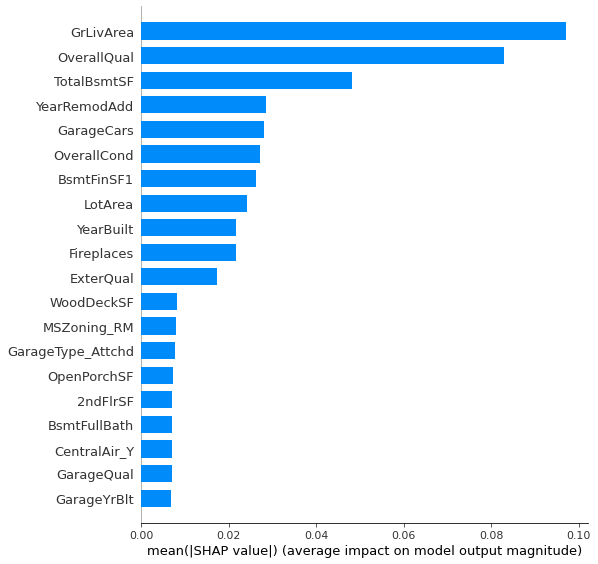

In [80]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(xgb_model)

train_df = pd.DataFrame(X_train, columns=all_features)

shap_values = explainer.shap_values(train_df, 
                np.log(data['SalePrice']), approximate=True)

shap.summary_plot(shap_values, train_df, plot_type = 'bar', 
                  feature_names = all_features)

We can see that the general living area and the overall quality of the house are the most important features. Afterwards we find the total basement squarefootage and the last year the house was refurbished. Also the number of cars that fit into the garage is a possible indicator for the price.

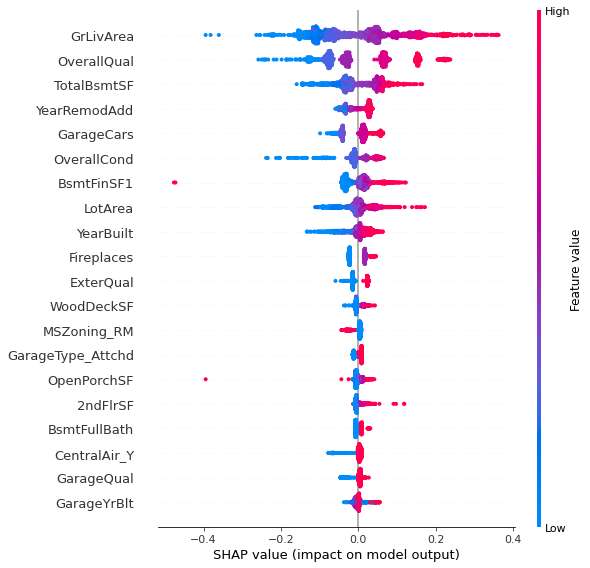

In [82]:
shap.summary_plot(shap_values, train_df)

An interesting next step is to understand how to devise features that can describe the living area better. Or perhaps we can try to decompose the general liv area into other, possible descriptive features by feature engineering.

Also we can see two small outliers here, these could be removed to enhance the overall rmse of the model (here rmse in the e-log space).